<div style="float:left">
    <h1 style="width:600px">Workshop 5: Advanced Clustering</h1>
    <h3 style="width:600px">CASA0006: Data Science for Spatial Systems</h3>
    <h3 style="width:600px">CASA0009: Spatial Data Capture, Storage and Analysis</h3>
    <h3 style="width:600px">Author: Huanfa Chen</h3>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

## Introduction

In this workshop, you will practice the following skills:

1. Using various clustering methods (e.g. kmeans, DBSCAN, hierarchical, max-p) to analyse the housing price and population data in London; 
2. Describing and analysing the clustering results;
3. Selecting the key parameters for clustering using Elbow method.

## Preparation
We will download the GIS and London housing data from the London DataStore. Here, we will practice with Linux/Windows commands to automatically download the data. If you are not familiar with these commands, you can download the data by visiting the URL in the browser and then saving the dataset to a folder. 

*Hint: make sure that you put the dataset in the same folder as this Python notebook.*

In [100]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from math import ceil

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from esda.adbscan import ADBSCAN

from scipy.cluster.hierarchy import dendrogram

import spopt
from spopt.region import MaxPHeuristic as MaxP
import matplotlib.pyplot as plt

import libpysal
import warnings

Next we will download the data. The ```wget``` command will work for Mac and Linux, but not for Windows. If you are using Windows and get the following error, don't panic - just open the url on your browser and save the zip file to an appropriate folder.

```
'wget' is not recognized as an internal or external command, operable program or batch file.
```

In [311]:
# note that this dataset contains all 7201 MSOAs in England. This dataset is used as it contains the high resolution boundary and neighbour topology of MSOAs 
url = 'https://github.com/jreades/fsds/raw/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip'

! wget $url

--2022-02-07 23:18:11--  https://github.com/jreades/fsds/raw/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jreades/fsds/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip [following]
--2022-02-07 23:18:11--  https://raw.githubusercontent.com/jreades/fsds/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7381177 (7.0M) [application/zip]
Saving to: ‘Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2

In [312]:
# gdf = gpd.read_file(f"zip://statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")
gdf = geopandas.read_file(f"zip://Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip!Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7201 entries, 0 to 7200
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    7201 non-null   int64   
 1   MSOA11CD    7201 non-null   object  
 2   MSOA11NM    7201 non-null   object  
 3   MSOA11NMW   7201 non-null   object  
 4   BNG_E       7201 non-null   int64   
 5   BNG_N       7201 non-null   int64   
 6   LONG        7201 non-null   float64 
 7   LAT         7201 non-null   float64 
 8   Shape__Are  7201 non-null   float64 
 9   Shape__Len  7201 non-null   float64 
 10  geometry    7201 non-null   geometry
dtypes: float64(4), geometry(1), int64(3), object(3)
memory usage: 619.0+ KB


Next, we will download the house price in a csv file from the [London DataStore](data.london.gov.uk). 

In [341]:
df = pd.read_csv('https://data.london.gov.uk/download/average-house-prices/bdf8eee7-41e1-4d24-90ce-93fe5cf040ae/land-registry-house-prices-MSOA.csv', na_values=[':'], low_memory=False)

In [342]:
print(df.shape)
measure = 'Mean'
year = 2017
df = df[(df.Year==f'Year ending Dec {year}') & (df.Measure==measure)].copy().reset_index()
df.drop(index=df[df.Value.isna()].index, inplace=True)
print(df.shape)

(262461, 5)
(983, 6)


In [343]:
df['Measure'] = df.Measure.astype('category')
df['Value'] = df.Value.astype('int')
df.drop(columns=['index'], inplace=True)

In [344]:
ppd = pd.merge(gdf, df, left_on='MSOA11CD', right_on='Code', how='inner').reset_index()
ppd.shape

(983, 17)

How many MSOAs are there in the **ppd** dataset? In other words, how many MSOAs are there in London?

In [ ]:
# ppd.shape[??]
ppd.shape[0]

983

In [314]:
ppd[ppd.Value.isin([ppd.Value.max(), ppd.Value.min()])][['index','MSOA11CD','MSOA11NM','Value']]

,index,MSOA11CD,MSOA11NM,Value
14,14,E02000016,Barking and Dagenham 015,226536
945,945,E02000978,Westminster 019,4416659


In [315]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [11]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

### Raw Distribution

What is the housing price distribution in London? We can use some plots and maps to showcase the distribution.

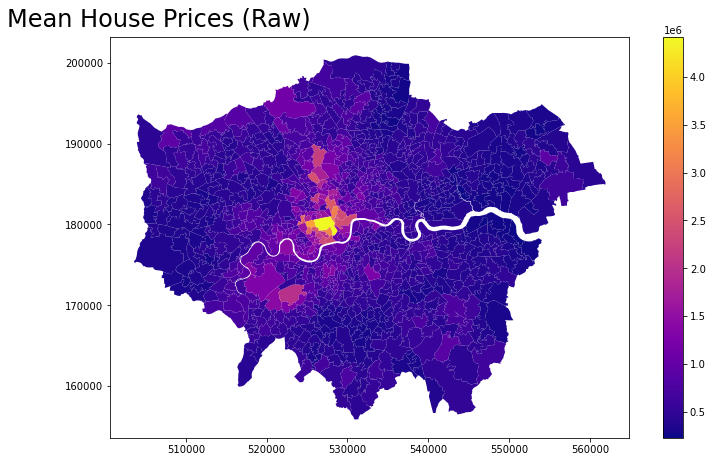

In [316]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='Value', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"{measure} House Prices (Raw)", x=0.025, size=24, **tfont);
plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

## Variable Selection and Standardisation

We will use the ```RobustScaler``` class from the ```sklearn``` package for standardising the dataset. Alternatively, you can use the ```MinMaxScaler``` class.

The RobustScaler is robust to outlier. It removes the median and scales the data according to the quantile range (defaults to between 25 quantile and 75 quantile, also called the Interquartile Range or IQR).

If you are not sure about these two classes, have a quick read of the documentation.

In [13]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [14]:
ppd.head()

,index,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,Code,Area,Year,Measure,Value
0,0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647....",E02000001,City of London 001,Year ending Dec 2017,Mean,950760
1,1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19...",E02000002,Barking and Dagenham 001,Year ending Dec 2017,Mean,296691
2,2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18...",E02000003,Barking and Dagenham 002,Year ending Dec 2017,Mean,320546
3,3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((551549.998 187364.637, 551478.000 18...",E02000004,Barking and Dagenham 003,Year ending Dec 2017,Mean,333292
4,4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((549099.634 187656.076, 549161.375 18...",E02000005,Barking and Dagenham 004,Year ending Dec 2017,Mean,323039


Here we focus on three variables: 

* ```POPDEN```: population density
* ```Value```: the mean house prices
* ```USUALRES```: number of usual residents
* ```HHOLDRES```: number of household residents

On the other hand, we should include the ```MSOA11CD``` variable as the index of MSOAs. If you want to know more about the ```index``` in a Pandas DataFrame (or Series), please read the documentation.

In [15]:
raw = ppd[['MSOA11CD','USUALRES','HHOLDRES', 'POPDEN','Value']].set_index('MSOA11CD').copy()
raw.head()

,USUALRES,HHOLDRES,POPDEN,Value
MSOA11CD,,,,
E02000001,7375,7187,25.5,950760
E02000002,6775,6724,31.3,296691
E02000003,10045,10033,46.9,320546
E02000004,6182,5937,24.8,333292
E02000005,8562,8562,72.1,323039


Plot a histogram of the mean house prices with 150 bins. Complete the code.

In [16]:
# raw.???.plot.hist(???=150)

<AxesSubplot:ylabel='Frequency'>

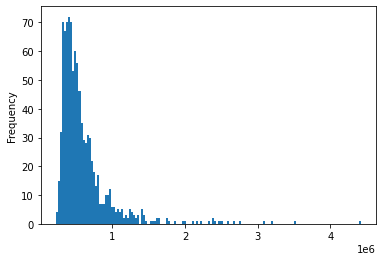

In [17]:
raw.Value.plot.hist(bins=150)

In [174]:
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()

The range of USUALRES is [-0.822266489597167, 1.8157923860115097]
The range of HHOLDRES is [-0.8089887640449438, 1.8519662921348314]
The range of POPDEN is [-0.5615273544039788, 1.3982031124659071]
The range of Value is [-0.42298461006180105, 6.178613843665502]


,USUALRES,HHOLDRES,POPDEN,Value
MSOA11CD,,,,
E02000001,-0.22,-0.25,-0.38,0.72
E02000002,-0.38,-0.38,-0.33,-0.31
E02000003,0.52,0.55,-0.21,-0.27
E02000004,-0.55,-0.60,-0.39,-0.25
E02000005,0.11,0.14,-0.01,-0.27


One important note on `scikit-learn`: the `scikit-learn` methods operate in a very similar fashion, regardless of the approach you are using. It uses the `.fit()` or `.fit_transform()` function execute the model and return results. Each model will take different arguments, but the same approach is used every time.

Make a scatter plot between **Value** (on the y axis) and **POPDEN** (on the x axis).

Think about this question: is it that the higher population density, the higher average house price?

In [25]:
# normed.plot.scatter(x= ???, y=???)

<AxesSubplot:xlabel='POPDEN', ylabel='Value'>

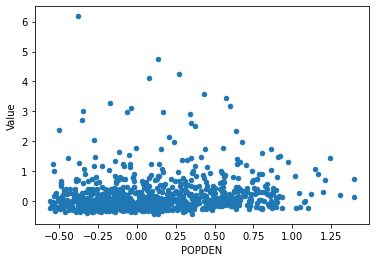

In [26]:
normed.plot.scatter(x='POPDEN', y='Value')

## DBSCAN

So, let's run the DBSCAN clustering method. According to the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), the model can take a number of parameters: the `eps` distance and `min_samples` group size attributes are fundamental in creating the clusters. I've suggested some values below, but we'll try amending those later.

### First DBSCAN

We implement a function for plotting the clustering results. Note that this function will be re-used across this notebook.

In [357]:
def mapping_clusters(clusters):
    ppd['cluster_nm'] = clusters
    ppd.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

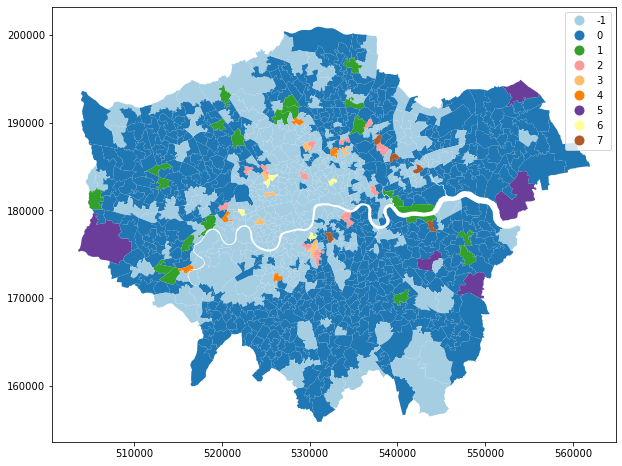

In [358]:
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.15
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)

# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
cluster_nm = dbsc.labels_

mapping_clusters(cluster_nm)

Some might think there are four clusters corresponding to four different colours - don't presume! If you understand DBSCAN, it classifies the points that are far away from others as outlier.

According to the DBSCAN [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), it says:

```
Noisy samples are given the label -1.
```

The MSOAs in blue (labelled -1) are actually noise samples. So the above map show there are THREE clusters.

How many MSOAs are there in each cluster?

We can summarise the number of MSOAs in each cluster, using the ```value_counts``` function.

In [123]:
ppd['DBSCAN_Cluster'].value_counts()

-1    850
 0    111
 1     13
 2      9
Name: DBSCAN_Cluster, dtype: int64

**So what do you think of the results? Do the clusters look useful or realistic?**

The next thing to do is measure the formation of the clusters. We can do this through a range of measures - described in detail here [here](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation). Most of these, however, require a groundtruth relating to how a cluster should look (e.g. help us supervise the creation of the clusters. In this case we do not have this.

The only measure that can help is the Silhouette Score, which calculates how close points are on average to points their clustered with, relative to points they are not clustered with.

The `scikit-learn` algorithm ([docs](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)) for Silhouette Score simply takes the data and the generated labels. A score closer to one indicates strong clustering, negative scores indicate poor clustering.

**Run the code below to first load the library, then extract the Silhouette Score for the clusters created above.**

In [122]:
from sklearn import metrics
metrics.silhouette_score(normed, clusters)

-0.31814253783814095

The best and worst value of the silhouette score is 1 and -1, respectively. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

Now you can change the value of ```eps``` and ```minPts``` and see whether the clustering quality has been improved. You can always use the Silhouette score to measure the clustering quality.

### Another DBSCAN: finding the 'right' parameters

Finding the 'right' paramters for DBSCAN is not an easy job and there is no perfect approach for this task. Here we will utilise the nearest neighbor structure for this task.

We presume the **minPts** as the number of variables plus one and then we will search for the 'right' value of **eps**. As minPts and eps are interrelated, it's easier to set minPts first and then eps is  a distance metric that governs how far away something can be from a cluster and still be considered part of that cluster.

WARNING. My feeling is that these results are far from satisfactory. The majority of items are assigned to one cluster and a small number of MSOAs are distinctly different from the others. 

We will firstly work out the NearestNeighbors plot, which inspires the appropriate range of **eps** parameter in DBSCAN.

The **NearestNeighbors** class provides the function to find the nearst few points to each point in the dataset.

In [81]:
nbrs = NearestNeighbors(n_neighbors=6).fit(normed)
distances, indices = nbrs.kneighbors(normed)
print("Shape of distances:" + str(distances.shape))
print(distances[0,:])
print(indices[0,:])

Shape of distances:(983, 6)
[0.         0.1338911  0.221716   0.24818013 0.29066728 0.29786282]
[  0 475 417 154 762 397]


The **kneighbors** function finds the K-neighbors of a point, and returns indices of and distances to the neighbors of each point. Note that the query point is considered its own neighbor.

For example, the nearest six neighbors of the 0-th point have the index of [0, 475, 417, 154, 762, 397], and their distance to the 0-th point is [0, 0.1338911, 0.221716, 0.24818013, 0.29066728, 0.29786282].

We are interested in the nearest five neighbors of each point (excluding the point itself), as we presume the minPts to 5, which is the number of columns plus one.

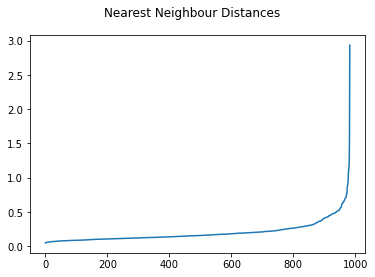

In [82]:
# extracting the column of the fifth nearest neighbor (excluding the point itself). Note that distances[:,0] has all values of 0.
distances = distances[:,5]
# sort the distance to the nearest neighor
distances = np.sort(distances)
# a line plot
plt.plot(distances)
plt.gcf().suptitle("Nearest Neighbour Distances");

You could choose the range of **eps** depending on how many points are considered as core points. For example, if you consider 600-to-800 points as core points, the corresponding range of **eps** would be [0.2, 0.3]. Therefore, we will search for the **eps** in this range.

In [83]:
c_nm = 'DBSCAN'

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

el  = []

max_clusters  = 10
cluster_count = 1

iters = 0

# we set minPts as the number of columns plus 1
minPts = normed.shape[1]+1

min_eps = 0.2
max_eps = 0.3
step_eps = 0.01

for e in np.arange(min_eps, max_eps, step_eps):
    
    if iters % 5==0: print(f"{iters} epsilons explored.") 
    
    # Run the clustering
    dbs = DBSCAN(eps=e, min_samples=minPts).fit(normed)
    
    # See how we did
    s = pd.Series(dbs.labels_, index=normed.index, name=c_nm)
    
    row = [e]
    data = s.value_counts()
    
    for c in range(-1, max_clusters+1):
        try:
            if np.isnan(data[c]):
                row.append(None)
            else: 
                row.append(data[c])
        except KeyError:
            row.append(None)
    
    el.append(row)
    iters+=1

edf = pd.DataFrame(el, columns=['Epsilon']+["Cluster " + str(x) for x in list(range(-1,max_clusters+1))])

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

print("Done.")

0 epsilons explored.
5 epsilons explored.
Done.


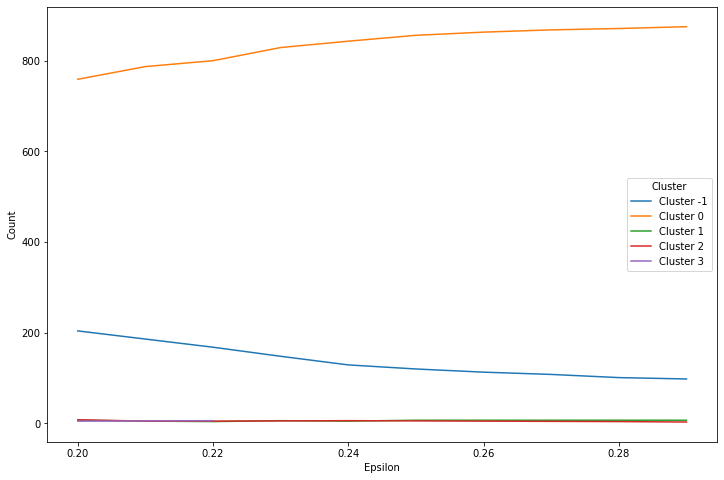

In [84]:
odf = pd.DataFrame(columns=['Epsilon','Cluster','Count'])

for i in range(0,len(edf.index)):
    row = edf.iloc[i,:]
    for c in range(1,len(edf.columns.values)):
        if row[c] != None and not np.isnan(row[c]):
            d = {'Epsilon':row[0], 'Cluster':f"Cluster {c-2}", 'Count':row[c]}
            odf = odf.append(d, ignore_index=True)

odf['Count'] = odf.Count.astype(float)

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=odf, x='Epsilon', y='Count', hue='Cluster');
# ax.vlines(0.06, 0, ax.get_ylim()[1], linestyle='dashed', color='r')

This graph provides some information on how the clusters change with different epsilon value. 

With the increase of eps value, there are less noisy points and small clusters (e.g. Cluster 2 and 3) are merged into the big cluster (Cluster 0).

When the eps value is greater than 0.22, there are only three clusters.

However, this graph can't automatically select the parameters for you. It depends on your judgement. One option is to choose eps = 0.28 as there are three clusters.

I have to say the result here is a 

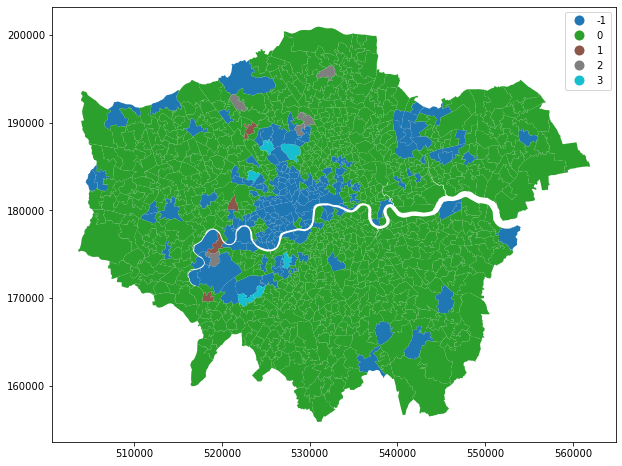

In [85]:
minPts = normed.shape[1]+1
epsilon = 0.22
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)

# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
clusters = dbsc.labels_

mapping_clusters(clusters)

## Kmeans

In this part, we will use the K-Means method on the same dataset. 

### The first Kmeans

First, you can try using k=3, as the result of DBSCAN indicates that there might be 4 clusters.

In [124]:
from sklearn.cluster import KMeans

The workflow of K-Means is very similar with that of DBSCAN.

In [88]:
k_cluster = 5
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=5, random_state=1)

You can visualise the clusters on the map.

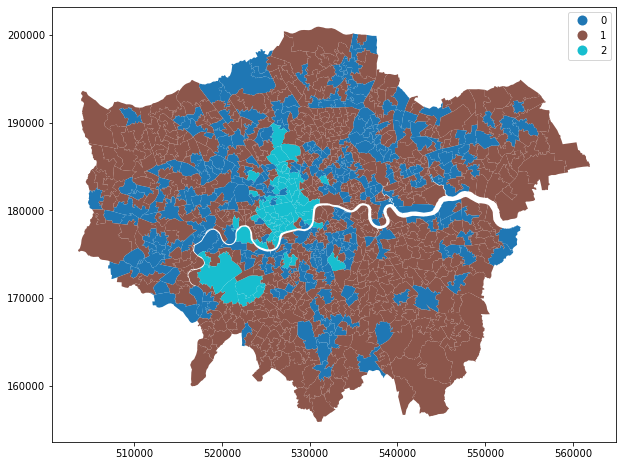

In [96]:
mapping_clusters(kmeans_method.labels_);

### Randonness of K-Means

K-Means involves randomness. The paramter of **random_state** controls the initialisation of the cluster centroids. If you change the value of random_state, you will probably get a different clustering. If you don't specify the random_state in the code, then every time you execute your code a new random value is generated and the train and test datasets would have different values each time.

The reason for setting the random_state here is to reproduce the result. But in practice, you are not encouraged to manipulate the result via testing with different random_state values.

A common practice with K-Means (and other algorithms involving randomness) is to run the algorithm many times using different random seeds and then choose the best result, such as the result with the lowest SSE. This is implemented in the function of K-Means. There is another parameter called **n_init**, which means the number of times the K-Means algorithm will be run with different centroid seeds. The **n_init** is default at 10. The final results will be the best output of n_init consecutive runs in terms of inertia (aka, SSE).

Read more about K-Means in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

### Finding the 'right' number of clusters

Next, you will try the Elbow method to choose the k value. The idea behind the Elbow method is to identify the value of k where the distortion begins to decrease most rapidly. At this value, if you continue to increase the k, you will not get much decrease on the SSE.

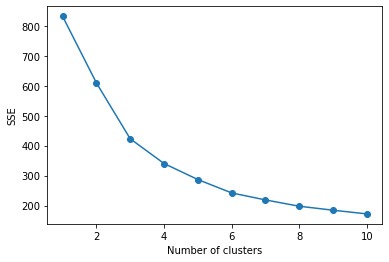

In [127]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

From the SSE plot, you can see that **three** might be the optimal k value. Can you re-run the K-Means function with k = 3?

In [90]:
# k_cluster = ??
# random_seed = ??
# kmeans_method = KMeans(??=??,??=??)
# kmeans_method.fit(??)

## plotting
## mapping_clusters(???.labels_);

In [91]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=3, random_state=1)

## Hierarchical clustering

We will test the Agglomerative Clustering (one type of hierarchical clustering) for this dataset. 

First, we will generate and plot the dendrogram from the clustering process. This shows the hierarchy of the clusters.

Given the hundreds of data points, the whole dendrogram starting from the individual level would be complicated and challenging to visualise. Therefore, we will show the top three levels of the dendrogram. 

The code of **plot_dendrogram** is largely based on this [tutorial](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py). More details about the dendrogram function from scipy is [here](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.cluster.hierarchy.dendrogram.html?highlight=dendrogram#scipy.cluster.hierarchy.dendrogram).

In [108]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90., **kwargs)

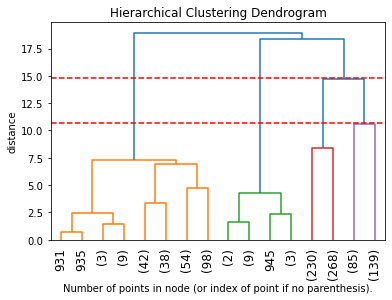

In [127]:
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(normed)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_cluster, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('distance')
plt.hlines(10.7, 0, ax.get_ylim()[1], linestyle='dashed', color='r')
plt.hlines(14.8, 0, ax.get_ylim()[1], linestyle='dashed', color='r')
plt.show()

The next task is to look at this dendrogram and understand the impact of different distance cut-offs on the clusters. 

This dendrogram shows that there is a big gap between the distance of 10.7 to the next merge (at the distance of around 14.8). Such distance gap in the dendrogram is pretty interesting, as it indicates that the next merge possibly shouldn't happen. In other words, it is likely the things that are merged here really don't belong to the same cluster, telling that four clusters are appropriate here.

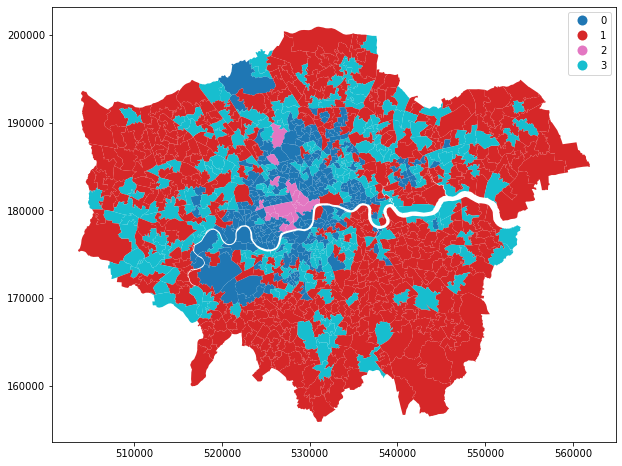

In [115]:
agg_cluster = AgglomerativeClustering(distance_threshold=None, n_clusters=4).fit(normed)
mapping_clusters(agg_cluster.labels_)

In [117]:
pd.Series(agg_cluster.labels_).value_counts()

1    498
3    246
0    224
2     15
dtype: int64

You can find the mapping from the four clusters to the clusters in the above dendrogram, using the number of points in each cluster.

In the above dendrogram with the cutoff distance of around 12.5, the four clusters from left and right corresponds to Cluster 3, 2, 1, and 0 in the map.

## Regionalisation: max-p problem

The clusters generated by DBSCAN/Kmeans/Hierarchical clustering methods are not spatially contiguous. In other words, a cluster is very likely to contain MSOAs that are not spatially connected.

Spatially constrained clustering, also called regionalisation, have been proposed to derive spatially contiguous clusters.

One such method is the max-p problem. It aims to generate a maximum number of clusters conditioning that:

1. Each cluster is spatially contiguous. In other words, each cluster is a region;
2. The sum of a variable (e.g. population) of each cluster is above a predefined threshold value. For example, the accumulative population of each cluster is above 10% of the total population.

So, the number of clusters generated by the max-p method is not predefined. 

This section is based on this [tutorial](https://pysal.org/spopt/notebooks/maxp.html).

In [361]:
plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

Here we aim to cluster the MSOAs into the maximum number of regions such that each region has at least 10% MOSAs and the homogeneity in several variables is maximised.

We first define the variables in the dataframe that will be used to measure regional homogeneity:

In [318]:
attrs_name = normed.columns.values.tolist()
attrs_name

['USUALRES', 'HHOLDRES', 'POPDEN', 'Value', 'count']

Next, we specify a number of parameters that will serve as input to the max-p model.

A spatial weights object expresses the spatial connectivity of the MSOAs:

In [345]:
w = libpysal.weights.Queen.from_dataframe(ppd)

5.7293997965412

Then we specify the minimum number of MSOAs contained by each region (threshold):

In [359]:
threshold = 0.3 * normed.shape[0]
print(threshold)
normed_copy = normed.copy()
normed_copy["count"] = 1
threshold_name = "count"

294.9


The max-p model can then be instantiated and solved. Note that this cell may take quite a long time to run. It takes ** minutes on a 24G Windows 10 desktop.

In [360]:
%%time
numpy.random.seed(RANDOM_SEED)
model = MaxP(normed_copy, w, attrs_name, threshold_name, threshold, top_n=3)
model.solve()

KeyboardInterrupt: 

## Wrap-up

Now that you've practiced four clustering methods, including DBSCAN, Kmeans, hierarchical, and max-p.

If you want to understand the computational complexity of each approach, you can record the time each approach takes to run. For this purpose, you should explore how to use the `time.time()` function to measure how long the `.fit()` function takes to complete. You can also put the `%%time` on the top of a cell to measure the computing time of this cell.

What's the next steps?

- Add a lot more comments to the code to ensure that really have understood what is going on.
- Try playing with some of the methods and parameters (e.g. replacing RobustScaler with MixMaxScaler, changing the number of clusters in hierarchical clustering) and seeing how your results change.
- Try outputting additional plots that will help you interpret your clustering results (e.g. what is the makeup of cluster 1? Or 6? What has it picked up? What names would I give these clsuters?).

## Credits!

### Acknowledgements:

This workshop is largely based on a [notebook](https://github.com/jreades/i2p/blob/master/lectures/10.2-Clustering-Housing.ipynb) developed by [Jon Reades](https://github.com/jreades). 

### Key references